In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging
import numpy as np

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from cross_defPlot import *
from cross_compute import *

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error', protocol = 'tcp://',
                      host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46845 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:46845/status,
Dashboard: http://137.129.155.67:46845/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:45591,Workers: 1
Dashboard: http://137.129.155.67:46845/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:48323,Total threads: 4
Dashboard: http://137.129.155.67:35817/status,Memory: 78.61 GiB
Nanny: None,


In [4]:
wave_OLR = ['TCWV_TD', 'TCWV_MJO', 'TCWV_Kelvin', 'TCWV_Rossby', 'TCWV_MRG', 'TCWV_EIG','TCWV_WIG']
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/TCWV/'
coeff = 1

ds = xr.open_mfdataset(indir_data + '*.nc', parallel = True)
ds = ds.sel(time = slice('2001','2019'))
# ds = ds.assign_coords(lon = (((ds.lon + 180) % 360) - 180)).sortby('lon')

indir_var = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/ANOMALY_FILTERED/'
season = 'YEAR'
ds_var = xr.open_mfdataset(indir_var + 'TCWV_' + season + '.nc')
ds_std = ds_var**(0.5)
ds_std

KeyboardInterrupt: 

In [ ]:
### Compute of gradient
for w in wave_OLR:
    ds = addNegative(ds, ds_std, w)
ds

In [ ]:
def keepData(ds, coeff, wave_REF):
    _ds = ds
    _ds[wave_REF] = xr.where( ((ds[wave_REF] <= (ds['STD_' + wave_REF +'_N'] * coeff)) | 
                                   (ds[wave_REF] >= (ds['STD_' + wave_REF] * coeff))) == True,
                                   _ds[wave_REF], np.nan)
    return _ds

In [ ]:
coeff = 1
for w in wave_OLR:
    ds_keep = keepData(ds, coeff, w)
    
    
# ds_FILTER = xr.open_dataset('/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/BOXAFRIQUE/mean_OLR_TCWV_wave.nc')


In [ ]:
ds_nb_jour = ds_keep_Kelvin.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0
# ds_nb_jour.groupby('time.month').mean()
ds_nb_jour

In [ ]:
from scipy.signal import find_peaks

ds_keep_Kelvin = ds_keep['TCWV_Kelvin'].sel(lat = 0, method = 'nearest').compute()

for l in range(ds_keep_Kelvin.lon.size):
    print(l , ' on ', ds_keep_Kelvin.lon.size)
    numpy_data = ds_keep_Kelvin.isel(lon = l)
    maxm, _ = find_peaks(numpy_data * -1, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('TCWV ondes de Kelvin')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

In [ ]:
ds_keep_Rossby = ds_keep['TCWV_Rossby'].sel(lat = 10, method = 'nearest').compute()
ds_nb_jour = ds_keep_Rossby.astype('int').copy()
ds_nb_jour = ds_nb_jour * 0

for l in range(ds_keep_Kelvin.lon.size):
    print(l , ' on ', ds_keep_Rossby.lon.size)
    numpy_data = ds_keep_Rossby.isel(lon = l)
    maxm, _ = find_peaks(numpy_data, distance = 20)
    for m in maxm :
        ds_nb_jour[m,l] = 1
        
data_plot = ds_nb_jour.groupby('time.month').sum()

plt.rc("figure", figsize=(16,5))
plt.figure()
data_plot.plot(cmap = 'jet', yincrease=False, yticks = np.arange(1,13))
plt.title('TCWV ondes de Rossby')
plt.xlabel('longitude')
plt.ylabel('mois')
plt.show()

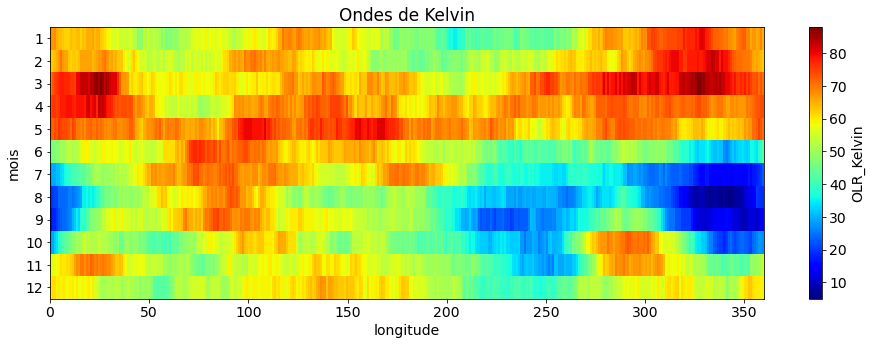